# ADS 509 Sentiment Assignment

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import string
import matplotlib.pyplot as plt
import seaborn as sns

sw = stopwords.words("english")

In [25]:
# Location of data on machine
data_location = r"C:\Users\Halee\Downloads\M1AssignmentData"

# Define subfolders
twitter_folder = os.path.join(data_location, "M1Results", "twitter")
lyrics_folder = os.path.join(data_location, "M1Results", "lyrics")


positive_words_file = pd.read_csv("positive-words.txt", skiprows=34, header = None, names = ['word']) 
negative_words_file = pd.read_csv("negative-words.txt", skiprows=34, header = None, names = ['word'])
tidy_text_file = pd.read_csv("tidytext_sentiments.txt", delimiter = '\t')

## Data Input

In [5]:
# Read in the lyrics data
# CODE ASSISTED BY CHATGPT4O
# Create function to combine lyrics data into one dataframe
def combine_lyrics_to_dataframe(directory):
    data = []  # Create empty list to append data to

    # Iterate through all files in the directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):  # Specify to find text files with lyric data
                try:
                    # Get the artist name from the parent folder
                    artist = os.path.basename(root)

                    # Read the content of the file
                    file_path = os.path.join(root, file)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        lines = f.readlines()

                    # Get the song name from the first line of the file
                    songname = lines[0].strip()

                    # Combine the rest of the lines into lyrics
                    lyrics = ''.join(lines[1:]).strip()

                    # Append the data to the list
                    data.append([artist, songname, lyrics])

                except Exception as e:
                    print(f"Error processing file {file}: {e}")  # Add bug readout

    # Create the DataFrame
    if data:
        df = pd.DataFrame(data, columns=['artist', 'songname', 'lyrics'])
    else:
        df = pd.DataFrame(columns=['artist', 'songname', 'lyrics'])

    return df

# Compile lyrics by applying function to specified file path of lyric data
lyrics_df = combine_lyrics_to_dataframe(lyrics_folder)
lyrics_df  # Confirm both artists were added

,artist,songname,lyrics
0,cher,"""88 Degrees""","Stuck in L.A., ain't got no friends \nAnd so H..."
1,cher,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane\nWo...
2,cher,"""After All""","Well, here we are again\nI guess it must be fa..."
3,cher,"""Again""",Again evening finds me at your door \nHere to ...
4,cher,"""Alfie""","What's it all about, Alfie?\nIs it just for th..."
...,...,...,...
415,robyn,"""We Dance To The Beat""",We dance to the beat\nWe dance to the beat\nWe...
416,robyn,"""Where Did Our Love Go""",Thoughts about you and me \nThinkin' about wha...
417,robyn,"""Who's That Girl""",Good girls are pretty like all the time\nI'm j...
418,robyn,"""With Every Heartbeat""",Maybe we could make it all right\nWe could mak...


In [6]:
# Read in the twitter data
# CODE ASSISTED BY CHATGPT4O
# Creat function to read in Twitter data
def combine_twitter_to_dataframe(directory):
    data = []

    # Iterate through all files in the directory
    for root, _, files in os.walk(directory):
        for file in files:
            if "_data" in file and file.endswith(".txt"):  # Confirm files are text files that contain follower data
                try:
                    # Read the content of the file as tab-delimited, skipping bad lines
                    file_path = os.path.join(root, file)
                    
                    # Read in files as tab-delimited dataframe
                    # Skip lines that have missing data or abnormal structure
                    df_temp = pd.read_csv(file_path, delimiter='\t', on_bad_lines = 'skip')

                    # Extract the artist name from the file name since its the first keyword 
                    artist = file.split('_')[0]

                    # Check if 'description' column exists in the df_temp
                    if 'description' in df_temp.columns:
                        # Append the artist name and the description column to the data list
                        for description in df_temp['description']:
                            data.append([artist, description])
                    else:
                        print(f"Column 'description' not found in file {file}")

                except Exception as e:
                    print(f"Error processing file {file}: {e}")

    # Create the final DataFrame
    if data:
        df = pd.DataFrame(data, columns=['artist', 'description'])
    else:
        df = pd.DataFrame(columns=['artist', 'description'])

    return df

# Compile twitter by applying function to specified file path of twitter data
twitter_df = combine_twitter_to_dataframe(twitter_folder)
twitter_df  # Confirm both artists were added along with descriptions

,artist,description
0,cher,NaN
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,csu
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...
...,...,...
4268136,robynkonichiwa,"singer of songs, type 1 diabetic, tired $jakel..."
4268137,robynkonichiwa,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...
4268138,robynkonichiwa,A year to change a life is still a year ✨😌
4268139,robynkonichiwa,Head of Consumer - Mango. Made in Melbourne. R...


# Cleaning the text data

In [40]:
# CODE ASSISTED BY CHATGPT4O
# Function to creat clean data
def clean_and_tokenize(text):
    # Explicitly remove apostrophes and quotes
    additional_punctuation = "’‘“”"  

    # Replace additional punctuation with empty string
    for char in additional_punctuation:
        text = text.replace(char, "")
        
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split on whitespace and fold to lowercase
    words = word_tokenize(text.lower())
    
    # Remove stopwords
    words = [word for word in words if word not in sw]
    
    return words

In [41]:
# Update Twitter data type to string
twitter_df['description'] = twitter_df['description'].astype('str')

# Update alternative NA descriptions to NA
twitter_df['description'] = twitter_df['description'].replace(['nan', 'NaN'], pd.NA)

# Fill in any missing values with empty strings
twitter_df['description'] = twitter_df['description'].fillna('')

In [42]:
# Apply text cleaning to twitter data
twitter_df['clean_text'] = twitter_df['description'].apply(clean_and_tokenize)

In [43]:
# Update lyrics data type to string
lyrics_df['lyrics'] = lyrics_df['lyrics'].astype('str')

# Fill in any missing values with empty strings
lyrics_df['lyrics'] = lyrics_df['lyrics'].fillna('')

# Apply text cleaning to lyrics data
lyrics_df['clean_text'] = lyrics_df['lyrics'].apply(clean_and_tokenize)

In [59]:
twitter_df.head()

,artist,description,clean_text
0,cher,,[]
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]"
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]"
3,cher,csu,[csu]
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...,"[writer, washinformer, spelmancollege, alumna,..."


In [60]:
lyrics_df.head()

,artist,songname,lyrics,clean_text,sentiment_score,sentiment_label
0,cher,"""88 Degrees""","Stuck in L.A., ain't got no friends \nAnd so H...","[stuck, la, aint, got, friends, hollywood, nut...",0,neutral
1,cher,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane\nWo...,"[world, crazy, sane, would, strange, cant, bel...",0,neutral
2,cher,"""After All""","Well, here we are again\nI guess it must be fa...","[well, guess, must, fate, weve, tried, deep, i...",0,neutral
3,cher,"""Again""",Again evening finds me at your door \nHere to ...,"[evening, finds, door, ask, could, try, dont, ...",0,neutral
4,cher,"""Alfie""","What's it all about, Alfie?\nIs it just for th...","[whats, alfie, moment, live, whats, sort, alfi...",0,neutral


# Combine all word lists into a lexicon dataframe

In [35]:
positive_words_file['sentiment'] = 1
positive_words_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       2006 non-null   object
 1   sentiment  2006 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.5+ KB


In [36]:
negative_words_file['sentiment'] = -1
negative_words_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4783 entries, 0 to 4782
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       4783 non-null   object
 1   sentiment  4783 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.9+ KB


In [85]:
negative_words_file.head(100)

,word,sentiment
0,2-faced,-1
1,2-faces,-1
2,abnormal,-1
3,abolish,-1
4,abominable,-1
...,...,...
95,ailing,-1
96,ailment,-1
97,aimless,-1
98,alarm,-1


In [38]:
tidy_text_file['sentiment'] = tidy_text_file['sentiment'].apply(lambda x: 1 if x == 'positive' else -1)
tidy_text_file = tidy_text_file[['word', 'sentiment']]
tidy_text_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15133 entries, 0 to 15132
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       15133 non-null  object
 1   sentiment  15133 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 236.6+ KB


In [39]:
word_df = pd.concat([positive_words_file, negative_words_file, tidy_text_file], ignore_index=True)
word_df.head(), word_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21922 entries, 0 to 21921
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       21922 non-null  object
 1   sentiment  21922 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 342.7+ KB


(        word  sentiment
 0         a+          1
 1     abound          1
 2    abounds          1
 3  abundance          1
 4   abundant          1,
 None)

## Sentiment Analysis on Songs

In [62]:
# Define the sentiment scoring function
def calculate_sentiment(text, lexicon_df):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    words = text.lower().split()
    
    # Create a dictionary from the lexicon DataFrame
    lexicon_dict = dict(zip(lexicon_df['word'], lexicon_df['sentiment']))
    
    # Calculate the sentiment score
    sentiment_score = sum([lexicon_dict.get(word, 0) for word in words])

    return sentiment_score

In [63]:
lyrics_df['sentiment_score'] = lyrics_df['clean_text'].astype(str).apply(lambda x: calculate_sentiment(x, word_df))

In [64]:
lyrics_df['sentiment_score']

0     -44
1     -41
2     -15
3      -6
4     -15
       ..
415   -98
416   -14
417   -44
418   -20
419    -8
Name: sentiment_score, Length: 420, dtype: int64

In [65]:
# Calculate the mean sentiment score for Cher's lyrics
cher_sentiment_mean = np.mean(lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'])
cher_sentiment_mean

-27.962025316455698

In [67]:
# Calculate the mean sentiment score for Robyn's lyrics
robyn_sentiment_mean = np.mean(lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'])
robyn_sentiment_mean

-39.375

## Cher top and bottom 3 scores

In [89]:
top_3_lowest_cher = lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'].nsmallest(3).index
top_3_highest_cher = lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'].nlargest(3).index
top_3_lowest_cher, top_3_highest_cher

(Index([16, 198, 69], dtype='int64'), Index([37, 35, 291], dtype='int64'))

In [90]:
# Print the text associated with the top 3 lowest sentiment scores
print("Top 3 Lowest Sentiment Scores Text:")
for index in top_3_lowest_cher:
    print(lyrics_df.iloc[index]['clean_text'])

# Print the text associated with the top 3 highest sentiment scores
print("\nTop 3 Highest Sentiment Scores Text:")
for index in top_3_highest_cher:
    print(lyrics_df.iloc[index]['clean_text'])

Top 3 Lowest Sentiment Scores Text:
['bang', 'bang', 'shot', 'bang', 'bang', 'hit', 'ground', 'bang', 'bang', 'awful', 'sound', 'bang', 'bang', 'baby', 'shot', 'five', 'six', 'rode', 'horses', 'made', 'sticks', 'wore', 'black', 'wore', 'white', 'would', 'always', 'win', 'fight', 'bang', 'bang', 'shot', 'bang', 'bang', 'hit', 'ground', 'bang', 'bang', 'awful', 'sound', 'bang', 'bang', 'baby', 'shot', 'seasons', 'came', 'changed', 'time', 'grew', 'called', 'mine', 'would', 'always', 'laugh', 'say', 'remember', 'used', 'play', 'bang', 'bang', 'shot', 'bang', 'bang', 'hit', 'ground', 'bang', 'bang', 'awful', 'sound', 'bang', 'bang', 'baby', 'shot', 'music', 'played', 'people', 'sang', 'church', 'bells', 'rang', 'echoes', 'gun', 'vowed', 'wed', 'one', 'youre', 'gone', 'dont', 'know', 'sometimes', 'cry', 'didnt', 'say', 'goodbye', 'didnt', 'take', 'time', 'lie', 'bang', 'bang', 'shot', 'bang', 'bang', 'hit', 'ground', 'bang', 'bang', 'awful', 'sound', 'bang', 'bang', 'baby', 'shot', 'bang', 

## Robyn top and botton 3 scores

In [91]:
top_3_lowest_robyn = lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'].nsmallest(3).index
top_3_highest_robyn = lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'].nlargest(3).index
top_3_lowest_robyn, top_3_highest_robyn

(Index([380, 381, 382], dtype='int64'), Index([325, 374, 398], dtype='int64'))

In [92]:
# Print the text associated with the top 3 lowest sentiment scores
print("Top 3 Lowest Sentiment Scores Text:")
for index in top_3_lowest_robyn:
    print(lyrics_df.iloc[index]['clean_text'])

# Print the text associated with the top 3 highest sentiment scores
print("\nTop 3 Highest Sentiment Scores Text:")
for index in top_3_highest_robyn:
    print(lyrics_df.iloc[index]['clean_text'])

Top 3 Lowest Sentiment Scores Text:
['free', 'love', 'free', 'baby', 'free', 'love', 'free', 'baby', 'boom', 'boom', 'boom', 'boom', 'boom', 'chica', 'boom', 'let', 'give', 'baby', 'chica', 'boom', 'chica', 'boom', 'chica', 'boom', 'chica', 'boom', 'chica', 'boom', 'chica', 'boom', 'free', 'love', 'free', 'baby', 'free', 'love', 'free', 'baby', 'boom', 'boom', 'boom', 'boom', 'boom', 'chica', 'boom', 'let', 'give', 'baby', 'ima', 'give', 'baby', 'ima', 'give', 'im', 'ready', 'lose', 'steady', 'light', 'heavy', 'city', 'sometimes', 'ugly', 'sometimes', 'pretty', 'never', 'know', 'get', 'cause', 'cant', 'control', 'cant', 'unfold', 'slow', 'ima', 'give', 'baby', 'ima', 'give', 'im', 'ready', 'lose', 'steady', 'light', 'heavy', 'city', 'sometimes', 'ugly', 'sometimes', 'pretty', 'never', 'know', 'get', 'cause', 'cant', 'control', 'cant', 'unfold', 'slow', 'free', 'love', 'free', 'baby', 'free', 'love', 'free', 'baby', 'boom', 'boom', 'boom', 'boom', 'boom', 'chica', 'boom', 'let', 'give',

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher had the higher average sentiment score, but both artists trend towards negative sentiment overall with no scores being overall positive.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Cher's three most negative songs have a lot of repetition of negative sentiment words. The first song says "bang" a lot, the second worst song has a lot of words about themes of struggle and fighting for perfection, and the third worse has words like scar, defense, and crash. For the three least negative songs, two of them are in spanish so the scoring is not going to be accurate, and the third one has kissing, dream, and true.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Robyn's most negative songs use words like "boom," "kills," and "cold." Robyn's least negative songs contain non-english words, and the words "want," "ready," and "good."

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.


Text(0.5, 0, 'Sentiment Score')

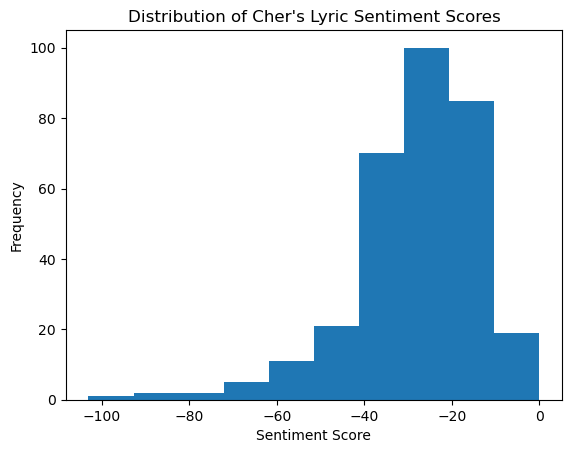

In [93]:
plt.hist(lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'])
plt.title("Distribution of Cher's Lyric Sentiment Scores")
plt.ylabel('Frequency')
plt.xlabel('Sentiment Score')

Text(0.5, 0, 'Sentiment Score')

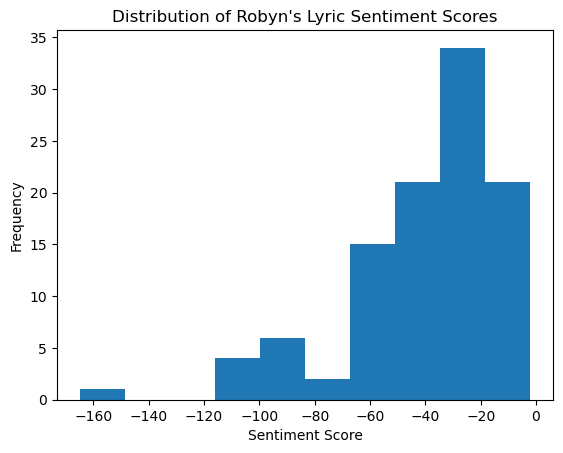

In [94]:
plt.hist(lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'])
plt.title("Distribution of Robyn's Lyric Sentiment Scores")
plt.ylabel('Frequency')
plt.xlabel('Sentiment Score')

## Sentiment Analysis on Twitter Descriptions

In [95]:
# Emoji list
positive_emojis = ['😀', '😃', '😄', '😁', '😊', '😇', '🙂', '🙌', '👍', '❤️'] 
negative_emojis = ['😞', '😟', '😠', '😡', '😢', '😭', '😩', '👎', '💔', '😤']


In [103]:
# Extract emojis and hashtags from clean text of descriptions
twitter_df['emojis'] = twitter_df['clean_text'].apply(lambda x: [char for char in x if char in positive_emojis + negative_emojis])

In [106]:
def calculate_emoji_sentiment(emojis, positive_emojis, negative_emojis):
    total_score = 0
    for emoji in emojis:
        if emoji in positive_emojis:
            total_score += 1
        elif emoji in negative_emojis:
            total_score -= 1
    return total_score

def get_average_sentiment(df, artist, positive_emojis, negative_emojis):
    artist_df = df[df['artist'] == artist]
    total_score = 0
    for emojis in artist_df['emojis']:
        total_score += calculate_emoji_sentiment(emojis, positive_emojis, negative_emojis)
    average_sentiment = total_score / len(artist_df)
    return average_sentiment

# Calculate average sentiment for each artist
average_sentiment_cher = get_average_sentiment(twitter_df, 'cher', positive_emojis, negative_emojis)
average_sentiment_robyn = get_average_sentiment(twitter_df, 'robynkonichiwa', positive_emojis, negative_emojis)

In [108]:
average_sentiment_cher, average_sentiment_robyn

(0.004944205017896985, 0.0035300236756016247)

In [109]:
def most_popular_emojis(df, artist, positive_emojis, negative_emojis):
    artist_df = df[df['artist'] == artist]
    emoji_counter = Counter([emoji for sublist in artist_df['emojis'] for emoji in sublist])
    
    # Find the most common positive and negative emojis
    most_common_positive = None
    most_common_negative = None
    max_positive_count = 0
    max_negative_count = 0
    
    for emoji, count in emoji_counter.items():
        if emoji in positive_emojis and count > max_positive_count:
            most_common_positive = emoji
            max_positive_count = count
        if emoji in negative_emojis and count > max_negative_count:
            most_common_negative = emoji
            max_negative_count = count
            
    return most_common_positive, most_common_negative

# Find the most popular emojis for each artist
most_popular_positive_cher, most_popular_negative_cher = most_popular_emojis(twitter_df, 'cher', positive_emojis, negative_emojis)
most_popular_positive_robyn, most_popular_negative_robyn = most_popular_emojis(twitter_df, 'robynkonichiwa', positive_emojis, negative_emojis)

# Display the results
print(f"Most Popular Positive Emoji for Cher: {most_popular_positive_cher}")
print(f"Most Popular Negative Emoji for Cher: {most_popular_negative_cher}")
print(f"Most Popular Positive Emoji for Robyn: {most_popular_positive_robyn}")
print(f"Most Popular Negative Emoji for Robyn: {most_popular_negative_robyn}")

Most Popular Positive Emoji for Cher: ❤️
Most Popular Negative Emoji for Cher: 💔
Most Popular Positive Emoji for Robyn: ❤️
Most Popular Negative Emoji for Robyn: 💔


Q: What is the average sentiment of your two artists? 

A: Cher's average sentiment is 0.00494 which is bascially neutral. Robyn's average sentiment is 0.00353 which is basically neutral. 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Cher and robyn both have the same most popular emojis, which is the regular heart and a broken heart. 

